# 0. mini BERT 만들기

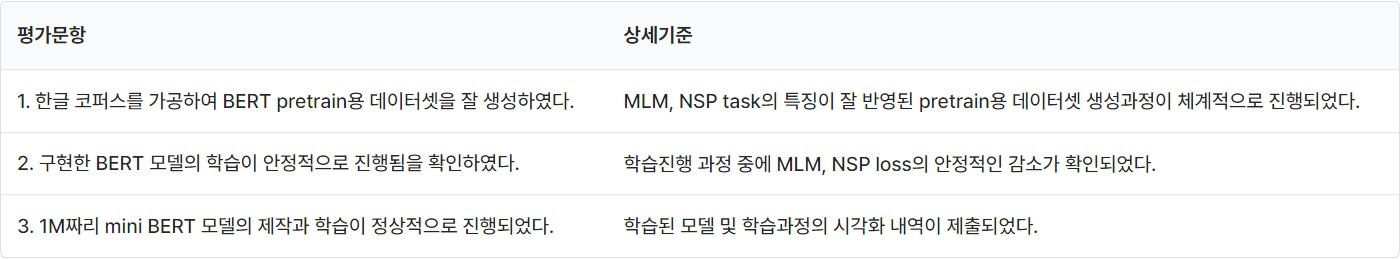

>지금까지 BERT 모델을 pretrain하는 험난한 여정을 잘 따라오셨나요?
>
>이번 프로젝트의 과제는 간단합니다.
>
>vocab size를 8000으로 줄이고, 전체 파라미터 사이즈가 1M 정도가 되는 아주 작은 mini BERT 모델을 만들어 10 Epoch까지 학습시킨 모델을 만들어 보는 것입니다.

mini BERT를 만들어보고 pretraining을 해보자.  
BERT는 트랜스포머의 인코더 부분만 떼어낸 모양새를 가진 LM이다.

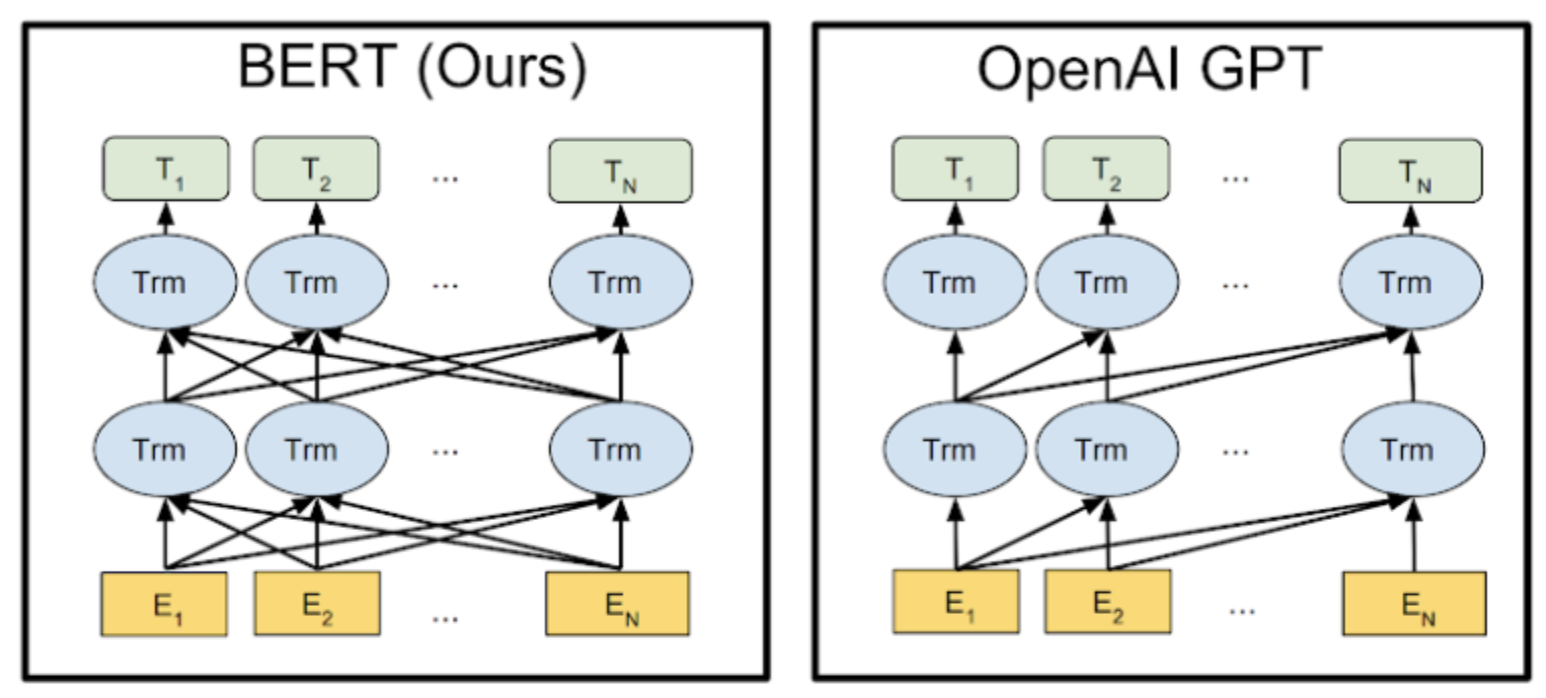

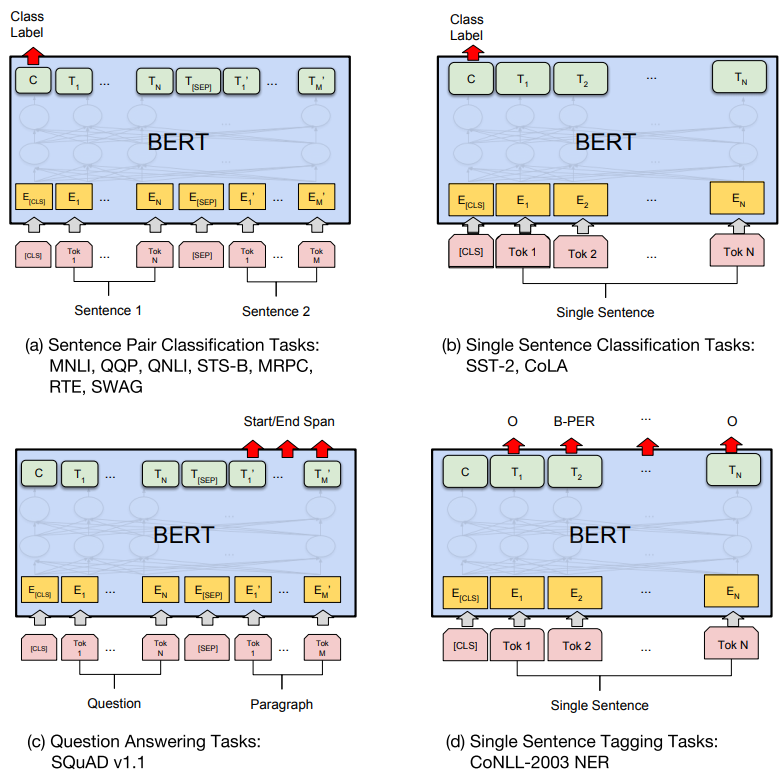

Task는 두 가지를 동시에 진행할 예정인데  
하나는 Masked Language Model(MLM)이고  
다른 하나는 Next Sentence Prediction(NSP)이다.

MLM은 "GPT의 Next Token Prediction 태스크처럼 다음이 이어질 단어는?"  
을 맞추는 게 아닌 "마스킹 된 다음 빈칸에 알맞은 단어는?"  
라는 문제를 푸는 형식으로 구성된다.

NSP는 어떤 문장 뒤에 실제로 다음에 오는 문장을 붙이거나 연관이 없는 문장을 뒤에 붙여서  
두 문장이 이어지는 내용인지 아닌지 문장 호응관계를 맞출 수 있게 하는 것이다.

결론적으로 보면 enc_token, segments 두 데이터를 이용해서
label_nsp, label_mlm 두 타겟을 예측하는 프로젝트이다.

In [1]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.initializers import TruncatedNormal
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


# 1. Tokenizer 준비

>SentencePiece 모델을 이용해 BERT의 MLM 학습용 데이터를 만드세요.
>
>이를 위해 한글 나무 위키 코퍼스로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 만들어 보세요.  
>BERT에 사용되는 주요 특수문자가 vocab에 포함되어야 합니다.  
>(시간이 부족하다면 클라우드에 저장된 sentencepiece 모델을 사용하세요.)

sentencepiece 모델을 생성해보자.

In [2]:
# 실행하길 원한다면 """ 를 지워주세요.
"""
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'
prefix = './models/ko_8000'
vocab_size = 8000

spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰
"""
print("완료")   # 완료메시지가 출력될 때까지 아무 출력내용이 없더라도 기다려 주세요.

완료


In [3]:
data_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/models'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_8000.model") 

True

In [4]:
# 특수 token 7개를 제외한 나머지 tokens 들
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))
print(vocab_list[: 10])

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다']


# 2. 데이터 전처리

## 2.1. MASK 생성

>BERT의 MLM에 필요한 빈칸(mask)을 학습 데이터 전체 토큰의 15% 정도로 만들어 주세요.  
>그 중 80%는 [MASK] 토큰, 10%는 랜덤한 토큰, 나머지 10%는 원래의 토큰을 그대로 사용하세요.

MLM을 하기 위한 데이터셋을 만든다.

In [5]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    # random mask를 위해서 순서를 섞음
    random.shuffle(cand_idx)

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0..1 사이의 확률 값
        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
    # mask_lms 정렬 후 mask_idx, mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]  # mask된 token의 index
    mask_label = [p["label"] for p in mask_lms]  # mask된 token의 원래 값

    return tokens, mask_idx, mask_label


## 2.2. NSP pair 생성

>BERT의 pretrain task인 NSP는 두 문장이 연속하는지 확인하는 것입니다.  
>이를 위해 2개의 문장을 짝지어 50%의 확률로 TRUE와 FALSE를 지정해 주세요.
>
>두 문장 사이에 segment 처리를 해주세요.  
>첫 번째 문장의 segment는 0, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [SEP] 등을 넣어주세요.
>
>MLM과 NSP는 동시에 학습된다는 것을 염두에 두고 학습 데이터를 구성해 보세요.

NSP을 하기 위한 데이터셋을 만든다.

In [6]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [7]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            # tokens & aegment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances


## 2.3. 데이터셋 완성

>BERT pretrain 데이터셋을 생성해, json 포맷으로 저장하세요.  
>데이터셋의 사이즈가 크므로np.memmap을 사용해 메모리 사용량을 최소화해 보세요.

json 파일로 저장한다.

In [8]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []
                

In [9]:
corpus_file = data_dir + '/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [10]:
pretrain_json_path = data_dir + '/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)


  0%|          | 0/3957761 [00:00<?, ?it/s]

In [11]:
# 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

918189

메모리 절약을 위해 np.memmap 타입으로 파일을 불러온다.

In [12]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)


In [13]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)


  0%|          | 0/128000 [00:00<?, ?it/s]

/tmp/ipykernel_283/2205850736.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_283/2205850736.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

data load early stop 128000 128000


In [58]:
# 처음 데이터 확인
pre_train_inputs[0][0], pre_train_inputs[1][0], pre_train_labels[0][0], pre_train_labels[1][0]


(memmap([   5,   10, 1605, 3599, 1755, 3630,   41, 3644,  830, 3624, 1135,
           52, 3599,   13,   81,   87, 1501, 2247,   25, 3779, 3873, 3667,
         3631, 3813, 3873, 4196, 3636, 3779, 3601,  249, 3725, 1232,   33,
           52, 3599,    6,    6,    6, 6322, 2780,   14, 1509,  168, 3877,
          414,  165, 1697, 4290, 3873, 3703, 3683,  593,   21, 5007,  399,
         1927, 3607,    6,    6,    6,    6,    6,    6,  103, 4313, 4290,
          613, 3638, 3718,   98, 3878, 3656,  256, 2543,  309,  337, 3735,
          181, 3616, 3603,  489,  376, 3599,    4,    6,    6,  207, 3714,
            6, 1042,  103, 3610, 3686, 3718,    6,    6,   37, 3418,  416,
          810, 3666, 3625,  131, 3662,    7, 3629,  203,  241, 3602, 1114,
         3724,  788,  243,    6,    6,    6,  663, 1647, 3682, 3682, 3625,
          203, 3008, 3625, 3616,   16, 3599,    4], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0

# 3. BERT 모델 구현

>pad mask, ahead mask 함수, gelu activation 함수, parameter initializer 생성 함수, json을 config 형태로 사용하기 위한 유틸리티 함수를 먼저 만들어 두세요.
>
>Embedding 레이어, Transformer encoder 레이어, BERT 레이어를 구성한 후, pretraine용 BERT 모델을 만들어 봅시다.

In [15]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask

In [16]:
def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

In [17]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))


In [18]:
# def kernel_initializer(stddev=0.02):
#     """
#     parameter initializer 생성
#     :param stddev: 생성할 랜덤 변수의 표준편차
#     """
#     return tf.keras.initializers.TruncatedNormal(stddev=stddev)

In [19]:
# def tf.zeros_initializer:
#     """
#     bias initializer 생성
#     """
#     return tf.zeros_initializer

In [20]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [21]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=TruncatedNormal(stddev=0.02)
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs
    

In [22]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=TruncatedNormal(stddev=0.02))

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed
    

In [23]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=tf.zeros_initializer)
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=tf.zeros_initializer)
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=tf.zeros_initializer)
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=tf.zeros_initializer)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out
    

In [25]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=tf.zeros_initializer)
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=tf.zeros_initializer)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val
    

In [26]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out
    

In [27]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=TruncatedNormal(stddev=0.02))
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed
    

In [28]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=tf.zeros_initializer)
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=tf.zeros_initializer)
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs
    

In [29]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model


# 4. pretrain 진행

>loss, accuracy 함수를 정의하고 Learning Rate 스케쥴링을 구현한 후, 10 Epoch까지 모델 학습을 시켜보세요.  
>학습을 진행할 때는 배치 사이즈에 유의하세요.

In [30]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴


In [31]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy


In [32]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr
    

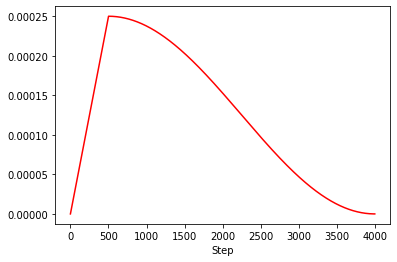

In [33]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

하이퍼 퍼래머더 지정.

In [34]:
config = Config({"d_model": 128,
                 "n_head": 4,
                 "d_head": 32,
                 "dropout": 0.1,
                 "d_ff": 512,
                 "layernorm_epsilon": 0.001,
                 "n_layer": 3,
                 "n_seq": 256,
                 "n_vocab": 0,
                 "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config


{'d_model': 128,
 'n_head': 4,
 'd_head': 32,
 'dropout': 0.1,
 'd_ff': 512,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}

In [38]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 128), (None, 1652992     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            16768       bert[0][0]                 

약 160만 개의 학습시켜야할 퍼래머더를 가진 모델이 생성되었다.

In [39]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})


train_steps: 20000


# 5. 프로젝트 결과

>학습된 모델과 학습과정을 시각화해 보세요.  
>NSP와 MLM의 loss가 안정적으로 수렴하나요?  
>모델이 작기 때문에 loss가 잘 수렴하지 않을 수도 있어요.

## 5.1. 학습 결과 확인

학습된 가중치를 저장할 수 있도록 체크포인트를 생성한다.

In [40]:
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])


Epoch 1/10
2000/2000 [==============================] - 151s 74ms/step - loss: 20.4127 - nsp_loss: 0.6605 - mlm_loss: 19.7522 - nsp_acc: 0.5733 - mlm_lm_acc: 0.0597

Epoch 00001: mlm_lm_acc improved from -inf to 0.05966, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 2/10
2000/2000 [==============================] - 150s 75ms/step - loss: 18.2232 - nsp_loss: 0.6302 - mlm_loss: 17.5930 - nsp_acc: 0.6116 - mlm_lm_acc: 0.1135

Epoch 00002: mlm_lm_acc improved from 0.05966 to 0.11345, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 3/10
2000/2000 [==============================] - 150s 75ms/step - loss: 17.4780 - nsp_loss: 0.6183 - mlm_loss: 16.8597 - nsp_acc: 0.6262 - mlm_lm_acc: 0.1282

Epoch 00003: mlm_lm_acc improved from 0.11345 to 0.12819, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 4/10
2000/2000 [==============================] - 150s 75ms/step - loss: 17.1040 - nsp_loss: 0.6139 - mlm_los

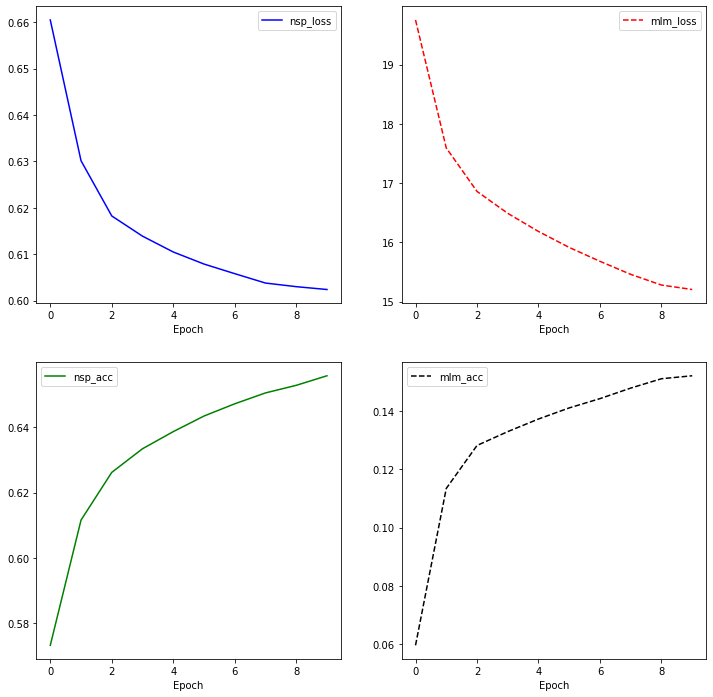

In [41]:
# training result
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

loss는 점점 낮아지고 accuracy는 점점 올라가는 모양새를 보아  
학습이 잘 되었다는 것을 알 수 있다.

## 5.2. 예측 결과 확인

첫번째 데이터를 살펴보자.

In [229]:
sample_enc_token = pre_train_inputs[0][: 1]
print(sample_enc_token)

[[   5   10 1605 3599 1755 3630   41 3644  830 3624 1135   52 3599   13
    81   87 1501 2247   25 3779 3873 3667 3631 3813 3873 4196 3636 3779
  3601  249 3725 1232   33   52 3599    6    6    6 6322 2780   14 1509
   168 3877  414  165 1697 4290 3873 3703 3683  593   21 5007  399 1927
  3607    6    6    6    6    6    6  103 4313 4290  613 3638 3718   98
  3878 3656  256 2543  309  337 3735  181 3616 3603  489  376 3599    4
     6    6  207 3714    6 1042  103 3610 3686 3718    6    6   37 3418
   416  810 3666 3625  131 3662    7 3629  203  241 3602 1114 3724  788
   243    6    6    6  663 1647 3682 3682 3625  203 3008 3625 3616   16
  3599    4]]


In [230]:
sample_segment = pre_train_inputs[1][: 1]
print(sample_segment)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


첫번째 target값을 살펴보자.

In [231]:
sample_label_nsp = pre_train_labels[0][: 1]
print(sample_label_nsp)

[0]


In [232]:
sample_label_mlm = pre_train_labels[1][: 1]
print(sample_label_mlm)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0  479 3652 3625  243    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  813   17 3599  307  587  931    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
    18 3686    0    0 3324    0    0    0    0    0  207 3714    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   49 3632  796    0    0    0    0    0    0    0    0    0    0
     0    0]]


첫번째 데이터에 대한 예측값을 출력해보자.

In [236]:
sample_pred_nsp_, sample_pred_mlm = pre_train_model.predict((sample_enc_token, sample_segment))

In [248]:
print('pred_nsp:', sample_pred_nsp.argmax(axis=1))
print('label_nsp:', sample_label_nsp)

pred_nsp: [0]
label_nsp: [0]


nsp는 잘 예측한 것을 볼 수 있다.

In [250]:
print('pred_mlm:', sample_pred_mlm.argmax(axis=2))
print('label_mlm:', sample_label_mlm)

pred_mlm: [[ 241   10 1605 3599 1755 3630   41 3644  830 3624 1135   52 3599   13
    81   87 1501 2247   25 3779 3873 3667 3631 3813 3873 4196 3636 3779
  3601  249 3725 1232   33   52 3599    8 3625 3600 3596 2780   14 1509
   168 3877  414  165 1697 3604 3873 3703 3683  593   21 3599  399 1927
  3607 3596 3596 3718 3616 3616   31  103 3601 3596  613 3638 3718   98
  3878 3656  256 2543  309  337 3735  181 3616 3603  489  376 3599    4
   416  416  207 3714  416 1042  103 3610 3686 3718  663 3662   37 3662
   416  810 3666 3625  131 3662    7 3629  203  241 3602 1114 3724  788
   243  241 3625 3599  663 1647 3682 3682 3625  203 3008 3625 3616   16
  3599 3625]]
label_mlm: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0  479 3652 3625  243    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  813   17 3599  307  5

label에서 0이 아닌 index의 값들만 비교하면 되는데(argmax의 특징)  
비교값들이 잘 보이지 않으므로 떼어내서 비교해 보겠다.

In [325]:
sample_pred = []
sample_label = []
for i, (e_id, p_id, l_id) in enumerate(zip(sample_enc_token[0], sample_pred_mlm.argmax(axis=2)[0], sample_label_mlm[0])):
    if e_id != 6:
        sample_pred.append(int(e_id))
        sample_label.append(int(e_id))
    else:
        print(f'{i+1}번째 MASK')
        print('pred_mlm:', vocab.id_to_piece(int(p_id)))
        print('label_mlm:', vocab.id_to_piece(int(l_id)))
        print()
        sample_pred.append(int(p_id))
        sample_label.append(int(l_id))

36번째 MASK
pred_mlm: ▁이
label_mlm: ▁195

37번째 MASK
pred_mlm: 년
label_mlm: 3

38번째 MASK
pred_mlm: 에
label_mlm: 년

58번째 MASK
pred_mlm: ▁
label_mlm: ▁벌

59번째 MASK
pred_mlm: ▁
label_mlm: 었다

60번째 MASK
pred_mlm: "
label_mlm: .

61번째 MASK
pred_mlm: )
label_mlm: ▁그의

62번째 MASK
pred_mlm: )
label_mlm: ▁별

63번째 MASK
pred_mlm: 했다
label_mlm: 명이

85번째 MASK
pred_mlm: (,
label_mlm: ▁지

86번째 MASK
pred_mlm: (,
label_mlm: 미

89번째 MASK
pred_mlm: (,
label_mlm: ▁제임스

95번째 MASK
pred_mlm: ▁대통령
label_mlm: ▁카

96번째 MASK
pred_mlm: 월
label_mlm: 터

114번째 MASK
pred_mlm: ▁)
label_mlm: ▁3

115번째 MASK
pred_mlm: 년
label_mlm: 9

116번째 MASK
pred_mlm: .
label_mlm: 번째



In [317]:
vocab.DecodeIds(sample_pred)

'[CLS]에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 이년에鬼 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을  "))했다 "땅콩 농부" (Peanut Farmer)로 알려졌다.[SEP](,(, 카터(, 얼 "지미" 대통령월 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 )년. 대통령 (1977년 ~ 1981년)이다.[SEP]'

In [316]:
vocab.DecodeIds(sample_label)

'[CLS]에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년鬼 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.[SEP] 지미 카터 제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령 (1977년 ~ 1981년)이다.[SEP]'

mlm에 대한 예측 성능은 ㅆㄹㄱ라고 볼 수 있다.  
accuracy가 0.2도 안되서 어쩌면 당연한 거라고 볼 수 있다.

# 6. 회고하기

드러나는 결과물이 딱히 없어서 이 프로젝트는 무엇을 하려고 하는 건지  
정확히 잘 모르겠어서 좀 더 살펴보았다.  
몇 개의 mask된 토큰을 포함한 문장 두 개를 sep(Separator) 토큰으로 합친 데이터를 이용해  
mask 토큰이 본래 무슨 토큰인지와 문장 두 개가 내용이 이어지는지  
두 가지를 예측하는 Two Task였고, Pretrain이 목표였기 때문에  
최종적으로 학습된 퍼래머더를 저장시킴으로써 프로젝트를 완성시켰다.